<a href="https://colab.research.google.com/github/praveenprabharavindran/MachineLearning/blob/main/Dogs_vs_Cats/InceptionV3/InceptionV3_Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!ls -al data*

In [2]:
#!unzip -q data.zip


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

def display_images(file_list, columns=5, figure_size=(12, 12)):
    num_images = len(file_list)

    # Calculate the number of rows needed to display the images
    rows = int(math.ceil(num_images / columns))

    # Create a figure with the specified size
    plt.figure(figsize=figure_size)

    for i, filename in enumerate(file_list):
        # Create each subplot and set the size
        plt.subplot(rows, columns, i + 1)
        plt.title(os.path.basename(filename))
        image = mpimg.imread(filename)

        # Set the size of the individual subplots
        plt.imshow(image)
        plt.axis('off')  # Turn off axis labels and ticks

    plt.tight_layout()  # Automatically adjust subplot parameters for a better layout
    plt.show()

In [4]:
import os

def list_files_in_directory(directory_path):
    full_paths = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, file))]
    return full_paths


In [5]:
train_cats_dir = 'data/train/cats'
train_dogs_dir = 'data/train/dogs'
test_cats_dir = 'data/test/cats'
test_dogs_dir= 'data/test/dogs'


train_cat_files = list_files_in_directory(train_cats_dir)
train_dog_files = list_files_in_directory(train_dogs_dir)
test_cat_files = list_files_in_directory(test_cats_dir)
test_dog_files = list_files_in_directory(test_dogs_dir)

First 25 cat files for training: 



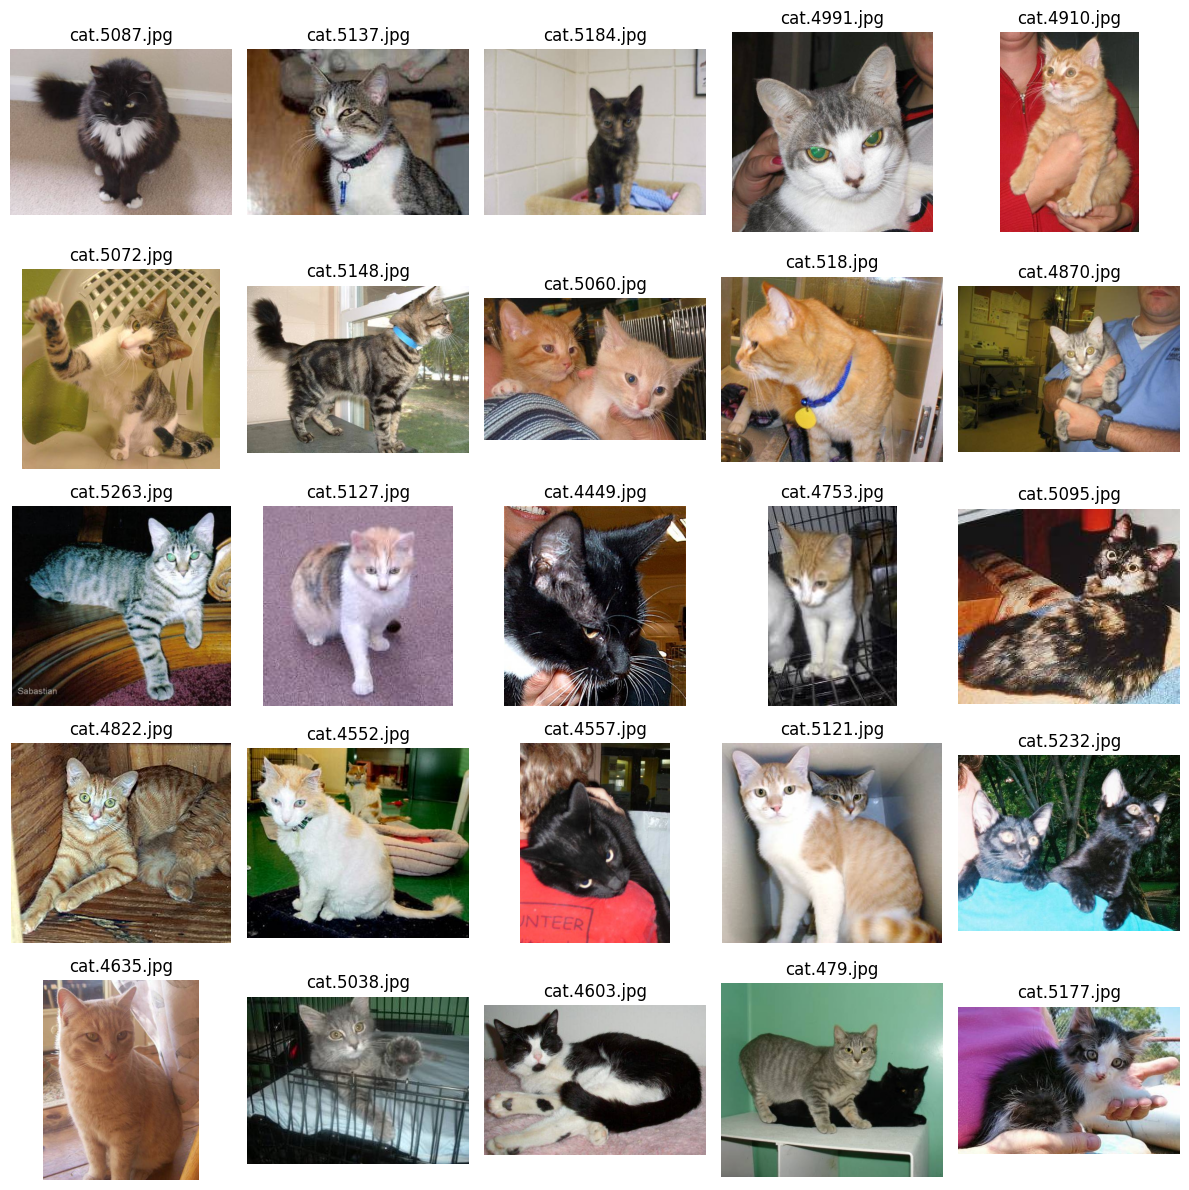

First 25 dog files for training: 



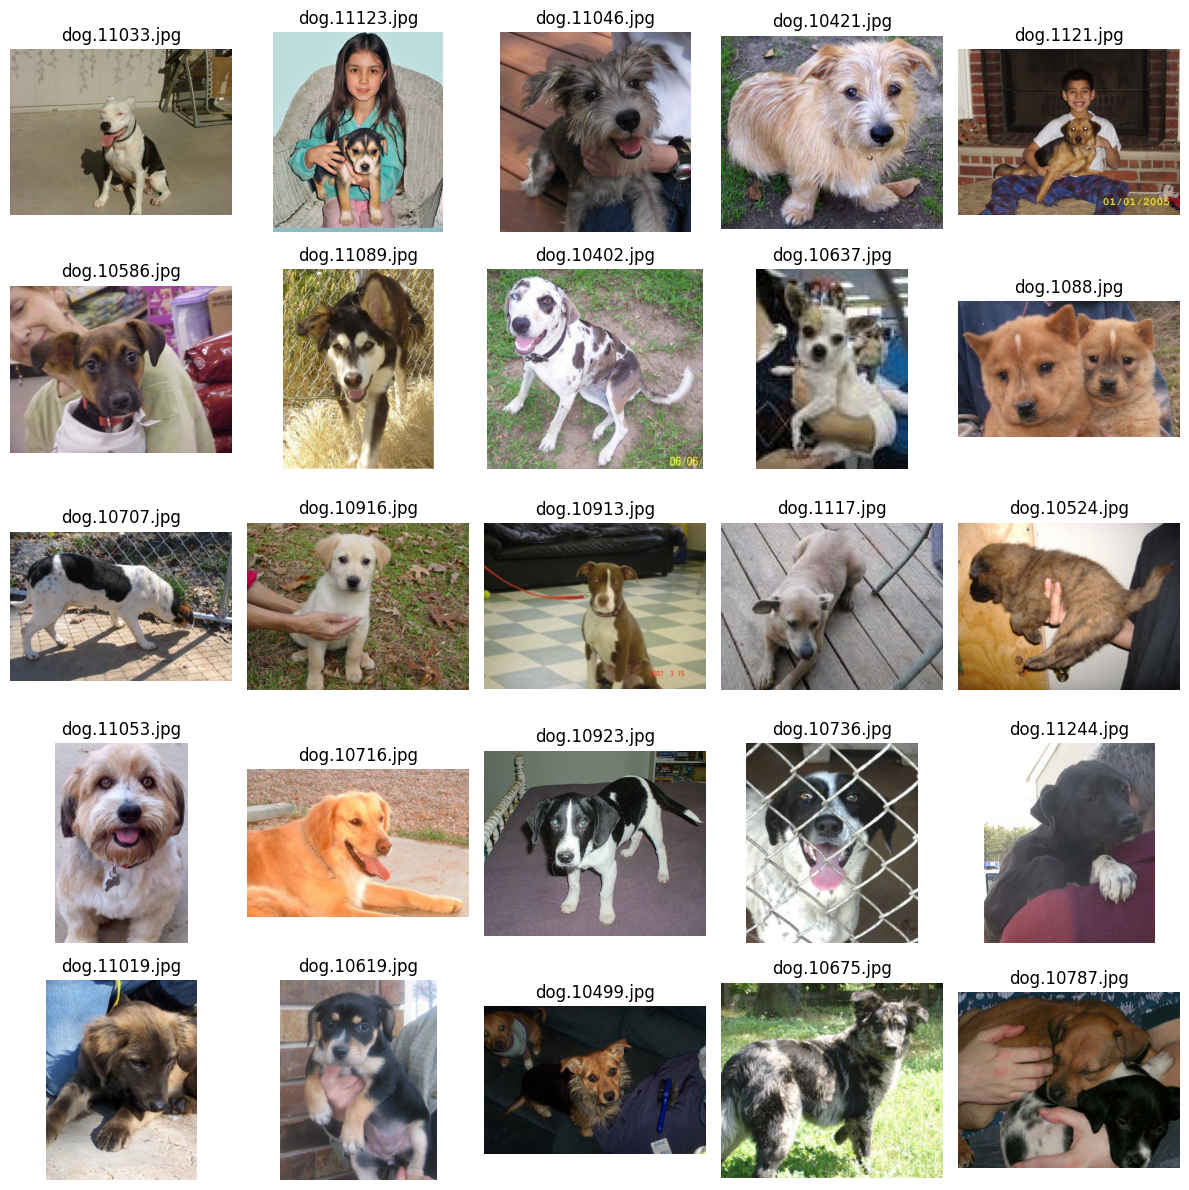

In [6]:
print('First 25 cat files for training: \n')
display_images(train_cat_files[:25],5)

print('First 25 dog files for training: \n')
display_images(train_dog_files[:25],5)

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define data directories
train_data_dir = 'data/train'
test_data_dir = 'data/test'

# Set the image size according to InceptionV3's input size
img_width, img_height = 299, 299
batch_size = 32

# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescale for test images (no augmentation)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Load and augment training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Load the InceptionV3 model pre-trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers on top of the pre-trained model for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(train_generator, epochs=3, steps_per_epoch=len(train_generator), validation_data=test_generator, validation_steps=len(test_generator))

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/3
63/63 [==============================] - 59s 780ms/step - loss: 0.1094 - accuracy: 0.9665 - val_loss: 0.3172 - val_accuracy: 0.9325
Epoch 2/3
63/63 [==============================] - 46s 731ms/step - loss: 0.0382 - accuracy: 0.9885 - val_loss: 0.0297 - val_accuracy: 0.9962
Epoch 3/3
63/63 [==============================] - 46s 730ms/step - loss: 0.0216 - accuracy: 0.9920 - val_loss: 0.0576 - val_accuracy: 0.9837


## Plot the accuracy of the model on training vs test data

<function matplotlib.pyplot.show(close=None, block=None)>

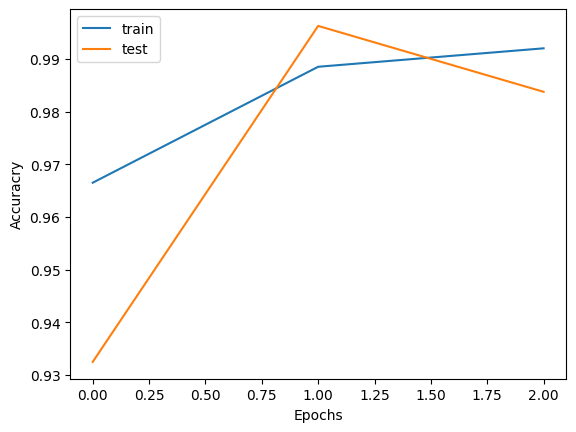

In [8]:
# plot the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracry')
plt.legend(['train','test'])
plt.show

## Plot the loss of the model on training vs test data

<function matplotlib.pyplot.show(close=None, block=None)>

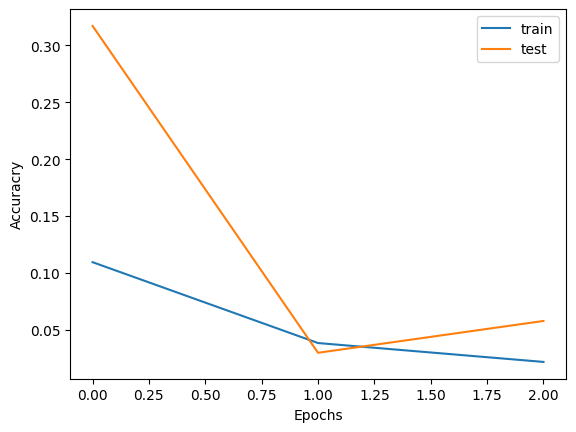

In [9]:
# plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Accuracry')
plt.legend(['train','test'])
plt.show


In [10]:
import pandas as pd
test_generator.reset
pred=model.predict(test_generator)
print(pred[:5])

25/25 [==============================] - 5s 134ms/step
[[9.9998128e-01]
 [9.9994719e-01]
 [9.9850863e-01]
 [1.7099934e-07]
 [8.0304835e-06]]


In [11]:
test_generator.class_indices

{'cats': 0, 'dogs': 1}

In [12]:
df=pd.DataFrame({'fileName':test_generator.filenames, 'predict_prob':pred[:,0],'y':test_generator.classes})
pd.set_option('display.float_format',lambda x:'%.5f' %x)
df['predicted_labels'] = df['predict_prob'].apply(lambda x: 1 if x > 0.5 else 0)

In [13]:
print(df[:5])

            fileName  predict_prob  y  predicted_labels
0  cats/cat.4003.jpg       0.99998  0                 1
1  cats/cat.4004.jpg       0.99995  0                 1
2  cats/cat.4005.jpg       0.99851  0                 1
3  cats/cat.4006.jpg       0.00000  0                 0
4  cats/cat.4007.jpg       0.00001  0                 0


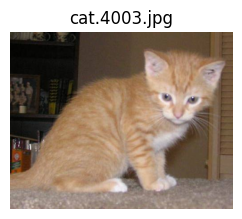

In [14]:
display_images(['data/test/cats/cat.4003.jpg'])